# TESS Light Curves for the JWST Early Release Science Exoplanet Data

We are all looking forward to the upcoming JWST release of several exquisite exoplanet transits. In anticipation of this release, we are providing reduced TESS time series, with TESS systematics removed for a set of exoplanet targets.

This notebook is designed to

1. Provide you with the TESS GI offices best reductions of exoplanet light curves for the JWST Early Release Science targets for planets:
 - HAT-P-18
 - HAT-P-14
 - L 168-9/ TOI-134
 - WASP-43b
 - WASP-18b
 - WASP-96b
2. Provide the reduction steps as Python functions.

This notebook is not a tutorial, and does not describe each step in detail. 

**The resultant files from this reduction are available as CSV and fits files inside this repository.**

## What are the reduction steps?

Each target is fit with a model built from:
   
1. The background estimated by local pixels
2. The TESS target centroids as estimated by the mission pipeline
3. A basis spline to model variability on timescales great than 1 day
4. A simple box transit model
5. Optionally, a phase-curve and eclipse model.

## What if I have questions?

If you want to know more about these light curves, or have questions, please reach out to the [TESS GI Helpdesk](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) and we'll be very happy to help you.

## How should I credit these light curves if I use them in my work?

If you would like to add authors to your publication having used these light curves, please reach out to the [TESS GI Helpdesk](https://heasarc.gsfc.nasa.gov/docs/tess/helpdesk.html) for appropriate names. If you would like to acknolwedge the use of these materials in your paper instead, please use something similar to:

```
This paper includes publicly available data products built by the NASA TESS Mission's General Investigator office to support JWST Early Release Science. These data products are avilable at \url{https://github.com/tessgi/JWST-ERS-Support}.

```

## TESS Mission Acknowledgement:

```
This paper includes data collected with the TESS mission, obtained from the MAST data archive at the Space Telescope Science Institute (STScI). Funding for the TESS mission is provided by the NASA Explorer Program. STScI is operated by the Association of Universities for Research in Astronomy, Inc., under NASA contract NAS 5–26555.

This research made use of: 
Lightkurve, a Python package for Kepler and TESS data analysis (Lightkurve Collaboration, 2018).  Astropy,\footnote{http://www.astropy.org} a community-developed core Python package for Astronomy \citep{astropy:2013, astropy:2018}. TESSCut (Brasseur et al. 2019), a package which runs Astrocut on MAST servers, and allows users to simply request cutouts through a web form or direct HTTP API query.  Astroquery (Ginsburg et al. 2019) a collection of tools for requesting archive data from databases hosted on remote servers with interfaces exposed on the internet.  


```

See more about citing Lightkurve [here](https://docs.lightkurve.org/about/citing.html), Astropy [here](https://www.astropy.org/acknowledging.html), TESSCut [here](https://ascl.net/code/v/2239), and Astroquery [here](https://github.com/astropy/astroquery#citing-astroquery).

In [57]:
import lightkurve as lk
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

enlarge_aper = lambda x: np.any(np.asarray(np.gradient(x.astype(float))) != 0, axis=0) | x

def bin(lc, nbins=10):
    """Quick function for binning light curves"""
    x, y, ye = np.asarray([np.hstack([i[:, 0].mean(axis=0),
                                  i[:, 1].mean(axis=0),
                                  ((i[:, 2]**2).sum(axis=0)**0.5)/i[:, 2].shape[0]]) 
                       for i in np.array_split(np.vstack([lc.time.value,
                                                          lc.flux.value,
                                                          lc.flux_err.value]).T, nbins)]).T
    return lk.LightCurve(time=x, flux=y*lc.flux.unit, flux_err=ye*lc.flux_err.unit, label=lc.label, targetid=lc.targetid)


def bin_bkg_columns(tpf):
    """Creates time series for each pixel column in the TPF, outside of the aperture"""
    bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)
    bkg = np.median(tpf.flux.value * ~bigger_pipeline_mask[None, :, :], axis=1)
    bkg = bkg[:, bkg.sum(axis=0) != 0]
    
    # Bin and interpolate for a smoother function
    binsize = int(np.round(0.00347/np.median(np.median(np.diff(tpf.time.value)))))
    breaks = np.hstack([0, np.where(np.diff(tpf.time.value) > 0.04)[0] + 1, len(tpf.time)])
    masks = [np.in1d(np.arange(len(tpf.time)), np.arange(a, b)) for a, b in zip(breaks[:-1], breaks[1:])]
    ts, bs = [], []
    for mask in masks:
        ts.append(np.asarray([i.mean() for i in np.array_split(tpf.time.value[mask], int(np.ceil(mask.sum()/binsize)))]))
        bs.append(np.asarray([i.mean(axis=0) for i in np.array_split(bkg[mask], int(np.ceil(mask.sum()/binsize)))]))
    ts, bs = np.hstack(ts), np.vstack(bs)
    return np.asarray([interp1d(ts, b, bounds_error=None, fill_value='extrapolate')(tpf.time.value) for b in bs.T]).T

def correct_transit_light_curve(tpf, bls, fit_eclipse=True):
    """Creates a systematics corrected light curve from a TPF, given a BLS object"""
    period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
    bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)

    phase_curve = (np.cos((tpf.time.value - t0) * (2 * np.pi)/period) * 0.5)
    transit = bls.get_transit_mask(period, dur, t0).astype(float)
    eclipse = bls.get_transit_mask(period, dur, t0 + period/2).astype(float)
    
    breaks = list(np.where(np.diff(tpf.time.value) > 0.1)[0] + 1)
    
    #dm1 = lk.DesignMatrix(np.nan_to_num(tpf.flux[:, ~bigger_pipeline_mask]), name='bkg').pca(2).split(breaks)
    bkg = bin_bkg_columns(tpf)
    dm1 = lk.DesignMatrix(bkg, name='bkg').split(breaks)
    dm2 = lk.DesignMatrix(transit[:, None], name='transit')
    dm3 = lk.DesignMatrix((phase_curve + eclipse)[:, None], name='eclipse')                
    dm4 = lk.DesignMatrix(np.nan_to_num(np.vstack([tpf.pos_corr1,
                                                   tpf.pos_corr2,
                                                   tpf.pos_corr1*tpf.pos_corr2]).T), name='centroids').split(breaks)
    spline = lk.designmatrix.create_spline_matrix(tpf.time.jd, n_knots=20).split(breaks)
    dm5 = lk.DesignMatrix(spline.X[:, spline.X.sum(axis=0) > 1e-5], name='spline')
    
    if fit_eclipse:
        dm = lk.DesignMatrixCollection([dm1, dm2, dm3, dm4, dm5])
    else:
        dm = lk.DesignMatrixCollection([dm1, dm2, dm4, dm5])
    lc = (tpf - np.median(tpf.flux[:, ~bigger_pipeline_mask].value, axis=1)[:, None, None]).to_lightcurve().normalize()
    r = lk.RegressionCorrector(lc)
    clc = r.correct(dm)

    # The RegressionCorrector has fit and removed out simple box model from `dm4`
    # We add the best fit box transit back into the light curve here
    clc += r.diagnostic_lightcurves['transit']
    if fit_eclipse:
        clc += r.diagnostic_lightcurves['eclipse']
    clc = clc[~r.outlier_mask]
    return clc, r

def get_tpfs(name, quality_bitmask="default"):
    """Obtain the fastest cadence tpfs for a target, and returns them as a collection"""
    tpfs1 = lk.search_targetpixelfile(name, author='SPOC', exptime=20).download_all(quality_bitmask=quality_bitmask)
    sectors = (list(set(list(np.arange(300))) - set(tpfs1.sector))) if tpfs1 is not None else None
    tpfs2 = lk.search_targetpixelfile(name, author='SPOC', sector=sectors, exptime=120).download_all(quality_bitmask=quality_bitmask)
    # Merge into one collection
    tpfs = lk.TargetPixelFileCollection([*tpfs1] if tpfs1 is not None else [] + [*tpfs2])
    # Clip out nan frames
    tpfs = lk.TargetPixelFileCollection([tpf[np.isfinite(tpf.flux.sum(axis=(1, 2))) & np.isfinite(tpf.flux_err.sum(axis=(1, 2)))] for tpf in tpfs])
    # Sort by time
    tpfs = lk.TargetPixelFileCollection([tpfs[i] for i in np.argsort(tpfs.sector)])    
    # Sort add pipeline background back in 
    tpfs = lk.TargetPixelFileCollection([tpf + np.nan_to_num(tpf.flux_bkg) for tpf in tpfs])    
    return tpfs

def get_corrected_lcs(name, period_estimate, fit_eclipse=True):
    tpfs = get_tpfs(name)
    corrected_lightcurves = []
    for tpf in tpfs:
        bigger_pipeline_mask = enlarge_aper(tpf.pipeline_mask)
        bkg = np.median(tpf.flux[:, ~bigger_pipeline_mask], axis=1)
        lc = (tpf - bkg[:, None, None]).to_lightcurve()
        bls = lc.to_periodogram(method='bls',
                            minimum_period=period_estimate - 0.05,
                            maximum_period=period_estimate + 0.05,
                            frequency_factor=10,
                            duration=np.linspace(0.01, 0.3, 50));
        period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
        clc, r = correct_transit_light_curve(tpf, bls, fit_eclipse=fit_eclipse)
        corrected_lightcurves.append(clc)
    return lk.LightCurveCollection(corrected_lightcurves)

In [60]:
x, y, ye = np.arange(1000), np.random.normal(1, 0.01, 1000), np.ones(1000) * 0.1

In [62]:
dm = lk.designmatrix.create_spline_matrix(x, knots=list(np.arange(1000, 10)))
dm

spline DesignMatrix (1000, 4)

# HAT-P-18

In [39]:
name = "HAT-P-18"
period_estimate = 5.508023
clcs = get_corrected_lcs(name, period_estimate, fit_eclipse=False)

/Users/ch/.pyenv/versions/3.8.7/lib/python3.8/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


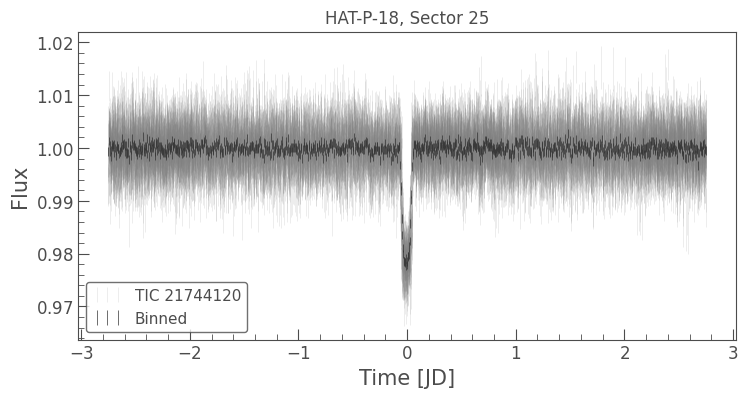

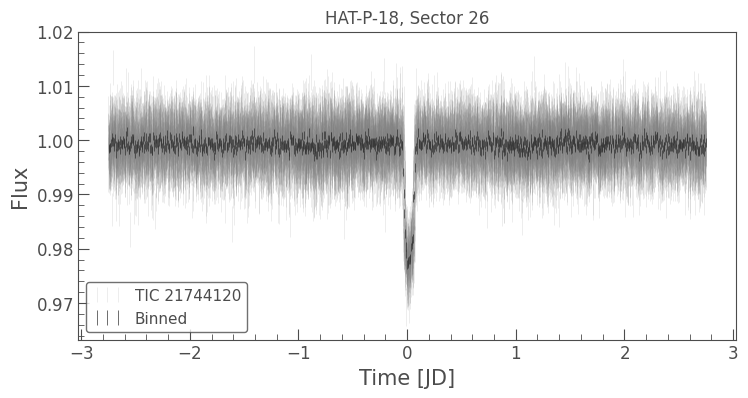

In [40]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [41]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)

# HAT-P-14

In [42]:
name = "HAT-P-14"
period_estimate = 4.6276
clcs = get_corrected_lcs(name, period_estimate, fit_eclipse=False)

/Users/ch/.pyenv/versions/3.8.7/lib/python3.8/site-packages/lightkurve/search.py:414: LightkurveWarning: Cannot download from an empty search result.
  warnings.warn(


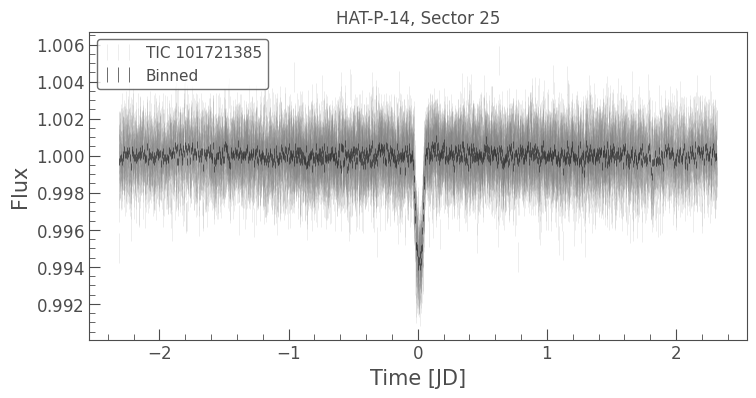

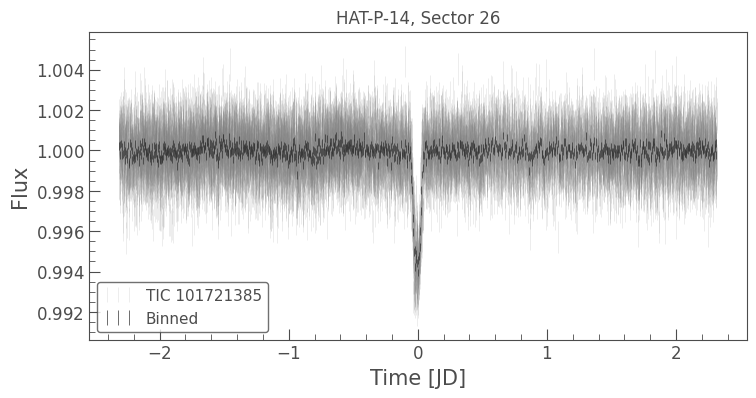

In [43]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [44]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)

# L 168-9/ TOI-134

In [45]:
name = "TOI-134"
period_estimate = 1.40150
clcs = get_corrected_lcs(name, period_estimate, fit_eclipse=False)

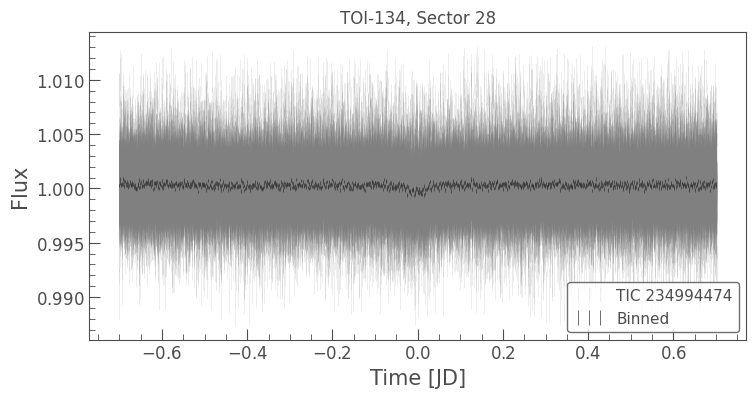

In [46]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [47]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)

# WASP-43b

In [48]:
name = "WASP-43"
period_estimate = 0.8134
clcs = get_corrected_lcs(name, period_estimate)

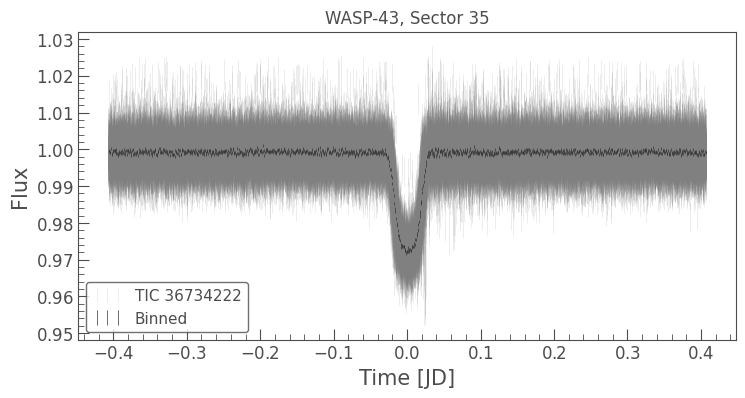

In [49]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [50]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)

# WASP-18b

In [51]:
name = "WASP-18"
period_estimate = 0.9414
clcs = get_corrected_lcs(name, period_estimate)

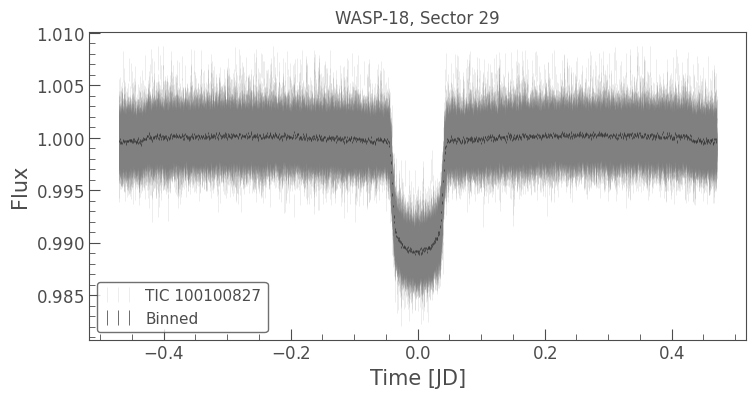

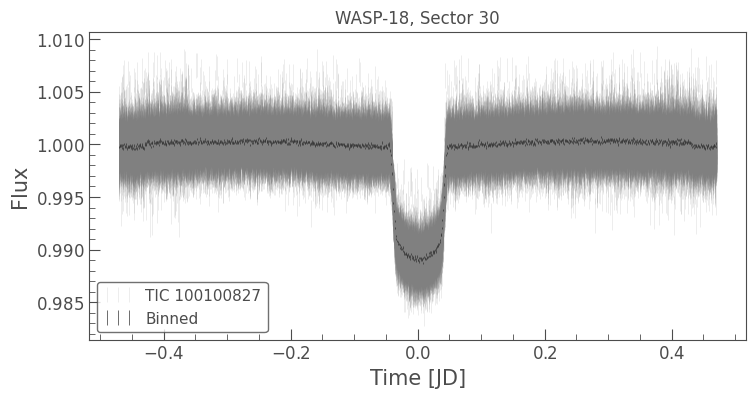

In [52]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [53]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)

# WASP-96b

In [54]:
name='WASP-96'
period_estimate = 3.4246
clcs = get_corrected_lcs(name, period_estimate)

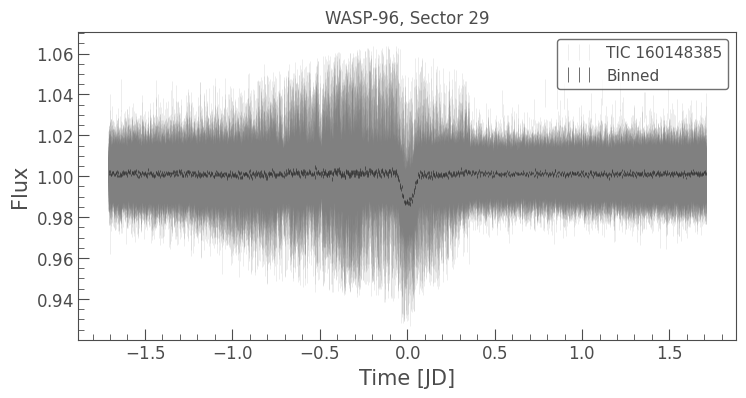

In [55]:
bls = clcs.stitch().to_periodogram(method='bls',
                    minimum_period=period_estimate - 0.005,
                    maximum_period=period_estimate + 0.005,
                    frequency_factor=100,
                    duration=np.linspace(0.01, 0.3, 50));
period, dur, t0 = bls.period_at_max_power.value, bls.duration_at_max_power.value, bls.transit_time_at_max_power.value
for clc in clcs:
    ax = clc.fold(period, t0).errorbar(color='grey', ls='', alpha=0.2)
    bin(clc.fold(period, t0), 1000).errorbar(ax=ax, label='Binned')
    ax.set(title=f'{name}, Sector {clc.sector}')

In [56]:
clcs.stitch().to_csv(f'{name}_TESS_CorrectedLC.csv', overwrite=True)
clcs.stitch().to_fits(f'{name}_TESS_CorrectedLC.fits', overwrite=True)